In [2]:
from helperClasses.DataPipeline import DataPipeline
from helperClasses.BaseTransformation import BaseTransformation
import pyzed.sl as sl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm

## SVO-File laden##
Die SVO-Dateien bitte nicht auf GIT pushen, da diese sehr groß sind. Jelle arbeitet an einer Lösung. Bis dann die SVO-Dateien mit lokalem Pfad laden.

In [3]:
svo_path = '../data/HD1080_SN35520970_11-03-24.svo'

**Methode zum zeichnen des Tennisfeldes**
Ist eine Hilfsmethode, die das Tennisfeld zeichnet. Kannst du ignorieren.

In [4]:
def drawTennisField():
    plt.plot([4.11, 4.11], [-11.89, 11.89], 'k', lw=2) # Single sideline rechts
    plt.plot([5.48, 5.48], [-11.89, 11.89], 'k', lw=2) # Double sideline rechts
    plt.plot([-4.11, -4.11], [-11.89, 11.89], 'k', lw=2) # Single sideline links
    plt.plot([-5.48, -5.48], [-11.89, 11.89], 'k', lw=2) # Double sideline links
    plt.plot([0, 0], [-6.41, 6.39], 'k', lw=2) # Center Service Line
    plt.plot([-5.48, 5.48], [0, 0], 'k', lw=2) # Net
    plt.plot([-5.48, 5.48], [11.89, 11.89], 'k', lw=2) # Baseline oben
    plt.plot([-5.48, 5.48], [-11.89, -11.89], 'k', lw=2) # Baseline unten
    plt.plot([-4.11, 4.11], [-6.40, -6.40], 'k', lw=2) # Service Line unten
    plt.plot([-4.11, 4.11], [6.40, 6.40], 'k', lw=2) # Service Line oben

## Datenaufbereitung ## 
Wenn du die Daten neu berechnen möchtest und nicht aus der vorhandenen CSV-Datei laden möchtest, dann führe die folgende Zelle aus. Ansonsten kannst du die darunterliegende Zelle ausführen.

In [5]:
zed = sl.Camera()

# init parameters
init_params = sl.InitParameters()
init_params.set_from_svo_file(svo_path)
init_params.depth_mode = sl.DEPTH_MODE.ULTRA
init_params.coordinate_units = sl.UNIT.METER
init_params.depth_maximum_distance = 40
init_params.depth_minimum_distance = 1
init_params.sdk_verbose = True

zed.open(init_params)
# init detection parameters
detection_parameters = sl.ObjectDetectionParameters()

detection_parameters.image_sync = True
detection_parameters.enable_tracking = True
detection_parameters.enable_segmentation = True

detection_parameters.detection_model = sl.OBJECT_DETECTION_MODEL.MULTI_CLASS_BOX_MEDIUM

if detection_parameters.enable_tracking:
    zed.enable_positional_tracking()

zed.enable_object_detection(detection_parameters)

detection_confidence = 20
detection_parameters_rt = sl.ObjectDetectionRuntimeParameters(detection_confidence)

detection_parameters_rt.object_class_filter = [sl.OBJECT_CLASS.PERSON, sl.OBJECT_CLASS.SPORT]
detected_objects = sl.Objects()
runtime_parameters = sl.RuntimeParameters()

detected_objects_list = []

while zed.grab(runtime_parameters) == sl.ERROR_CODE.SUCCESS:
    # Retrieve objects
    zed.retrieve_objects(detected_objects, detection_parameters_rt)

    frame_nr = zed.get_svo_position()

    for i, obj in enumerate(detected_objects.object_list):
        if obj.tracking_state == sl.OBJECT_TRACKING_STATE.OK:
            detected_objects_list.append({
                'obj': obj,
                'obj_nr': i,
                'frame_nr': frame_nr
            })
df_detected_objects = pd.DataFrame(
    data=[
        [
            obj['frame_nr'],
            obj['obj_nr'],
            obj['obj'].id,
            obj['obj'].label,
            obj['obj'].confidence,
            obj['obj'].tracking_state,
            obj['obj'].position[0],
            obj['obj'].position[1],
            obj['obj'].position[2],
            obj['obj'].velocity[0],
            obj['obj'].velocity[1],
            obj['obj'].velocity[2],
            obj['obj'].dimensions[0],
            obj['obj'].dimensions[1],
            obj['obj'].dimensions[2]
        ] for obj in detected_objects_list
    ],
    columns=['frame', 'object', 'object_id', 'object_label', 'confidence', 'tracking_state', 'x', 'y', 'z', 'vx', 'xy',
             'vz', 'width', 'height', 'length']
)
df_detected_objects.to_csv('df_detected_objects.csv', index=False, float_format='%.5f')

NameError: name 'sl' is not defined

In [6]:
data = pd.read_csv('df_detected_objects.csv') # Daten aus der CSV-Datei laden


calibration_points = np.array([
    [0.404, -1.434, -13.462], # service line center
    [3.263, -1.300, -11.118], # service x singles sideline
    [0.446, -1.444, -7.882] # baseline x singles sideline
])
bt = BaseTransformation(calibration_points)
data = bt.transformData(data, [-1.5, 0, -18.28])

dp = DataPipeline()
data = dp.mergePersons(data, 0.7, 0.1)

In [7]:
data

,frame,object,object_id,object_label,confidence,tracking_state,x,y,z,vx,xy,vz,width,height,length
1,3,1,1,Person,58.69141,OK,0.491703,-1.808712,13.248981,-3.77620,0.20816,-10.44296,0.79609,1.36517,0.79609
3,4,1,1,Person,57.95898,OK,0.545964,-1.802297,13.155637,-2.49269,0.16367,-8.05950,0.78589,1.36619,0.78589
5,5,1,1,Person,55.90820,OK,0.490332,-1.803161,13.285841,-1.44754,0.09919,-4.91755,0.77365,1.37026,0.77365
7,6,1,1,Person,50.00000,OK,0.491634,-1.801160,13.310953,-1.10440,0.07878,-3.91267,0.75425,1.37394,0.75425
9,7,1,1,Person,37.01172,OK,0.444338,-1.802547,13.393477,-0.81841,0.05096,-2.55268,0.73128,1.37605,0.73128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25381,10325,0,6,Person,90.03906,OK,7.807464,-0.848574,-17.006798,0.02334,0.00220,-0.09401,0.49989,0.31608,0.49989
25383,10326,0,6,Person,90.23438,OK,7.808461,-0.848025,-17.007186,0.02275,0.00216,-0.09162,0.49989,0.31417,0.49989
25385,10327,0,6,Person,90.23438,OK,7.809351,-0.847470,-17.007518,0.02215,0.00209,-0.08922,0.49990,0.31232,0.49990
25387,10328,0,6,Person,90.08789,OK,7.810077,-0.846933,-17.007788,0.02148,0.00201,-0.08652,0.49990,0.31056,0.49990


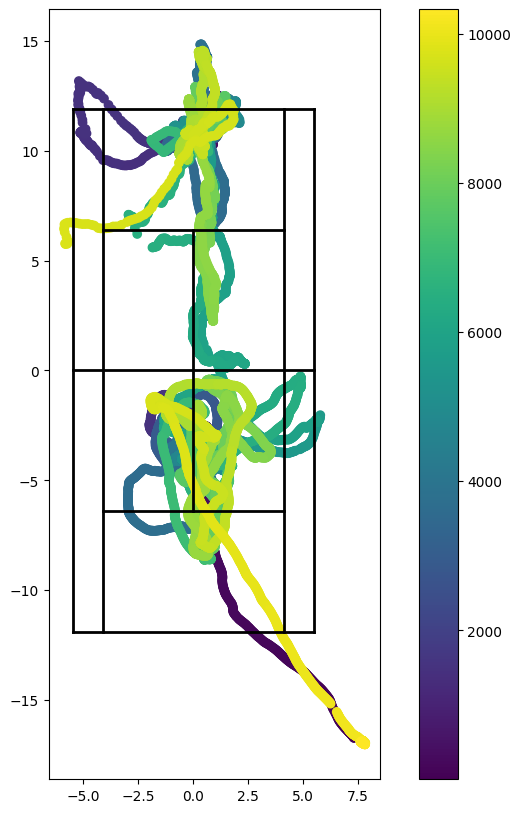

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(x=data['x'], y=data['z'], c=data['frame'], cmap='viridis')
drawTennisField()
plt.colorbar()
ax.set_aspect('equal')
plt.show()

## EDA ##

In [40]:
data.head()

,frame,object,object_id,object_label,confidence,tracking_state,x,y,z,vx,xy,vz,width,height,length,geschwindigkeit
1,3,1,1,Person,58.69141,OK,0.491703,-1.808712,13.248981,-3.77620,0.20816,-10.44296,0.79609,1.36517,0.79609,11.106684
3,4,1,1,Person,57.95898,OK,0.545964,-1.802297,13.155637,-2.49269,0.16367,-8.05950,0.78589,1.36619,0.78589,8.437762
5,5,1,1,Person,55.90820,OK,0.490332,-1.803161,13.285841,-1.44754,0.09919,-4.91755,0.77365,1.37026,0.77365,5.127135
7,6,1,1,Person,50.00000,OK,0.491634,-1.801160,13.310953,-1.10440,0.07878,-3.91267,0.75425,1.37394,0.75425,4.066312
9,7,1,1,Person,37.01172,OK,0.444338,-1.802547,13.393477,-0.81841,0.05096,-2.55268,0.73128,1.37605,0.73128,2.681150


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19604 entries, 1 to 25389
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   frame           19604 non-null  int64  
 1   object          19604 non-null  int64  
 2   object_id       19604 non-null  int64  
 3   object_label    19604 non-null  object 
 4   confidence      19604 non-null  float64
 5   tracking_state  19604 non-null  object 
 6   x               19604 non-null  float64
 7   y               19604 non-null  float64
 8   z               19604 non-null  float64
 9   vx              19604 non-null  float64
 10  xy              19604 non-null  float64
 11  vz              19604 non-null  float64
 12  width           19604 non-null  float64
 13  height          19604 non-null  float64
 14  length          19604 non-null  float64
dtypes: float64(10), int64(3), object(2)
memory usage: 2.4+ MB


In [24]:
data["object_id"] = data["object_id"].astype("category")
data["object"] = data["object"].astype("category")

In [16]:
data.isna().sum().sum()

0

In [21]:
data.duplicated().sum()

0

In [25]:
data.describe(include="all")

,frame,object,object_id,object_label,confidence,tracking_state,x,y,z,vx,xy,vz,width,height,length
count,19604.000000,19604.0,19604.0,19604,19604.000000,19604,19604.000000,19604.000000,19604.000000,19604.000000,19604.000000,19604.000000,19604.000000,19604.000000,19604.000000
unique,NaN,6.0,2.0,1,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,0.0,6.0,Person,NaN,OK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,9910.0,9957.0,19604,NaN,19604,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,5020.228933,NaN,NaN,NaN,76.148306,NaN,0.621249,-1.399405,2.721578,-0.010686,-0.000150,0.003906,0.762388,1.717896,0.762388
std,2920.071379,NaN,NaN,NaN,11.380958,NaN,1.407933,0.201091,7.950672,0.603392,0.014805,0.651048,0.167280,0.145745,0.167280
min,3.000000,NaN,NaN,NaN,20.239260,NaN,-5.877019,-1.961219,-17.007993,-4.524640,-0.104010,-10.442960,0.498400,0.308860,0.498400
25%,2488.000000,NaN,NaN,NaN,70.166020,NaN,0.127560,-1.582142,-3.826245,-0.360165,-0.009190,-0.399478,0.645540,1.706060,0.645540
50%,4940.500000,NaN,NaN,NaN,80.029300,NaN,0.483242,-1.404639,-0.601747,-0.016670,0.000610,-0.020135,0.723395,1.743255,0.723395
75%,7570.250000,NaN,NaN,NaN,84.521480,NaN,0.899212,-1.248651,10.998342,0.383798,0.008520,0.416310,0.835080,1.776080,0.835072


- Wir haben 19604 frames zur analyse.
- "objects" werden bis zu 6 erkennt wobei mehrheitlich 0 vorkommt.
- "object_id" ist die ID des Objekts. Es gibt 2 verschiedene IDs.
- "object_label" ist die Bezeichnung des Objekts. Es scheint als wäre diese Spalte überflüssig, da sie nur "Person" enthält.
- "confidence" ist die Wahrscheinlichkeit, dass das Objekt erkannt wurde. Der Median liegt bei 80% was ein gutes zeichen ist. Der Durchschnitt liegt bei 76% was unter dem Median liegt, dass zeigt uns das es ein paar Aufnahmen gibt, wo die Objekte nicht gut erkannt wurden. Mehrheitlich sind die Objekte gut erkannt worden.
- "tracking_state" ist der Status des Objekts. Diese Spalte scheint auch überflüssigzu sein, da sie nur "OK" enthält.
Die restlichen Spalten sind die Koordinaten der Spieler, da diese durchmischt sind werden sie erst bei der Visualisierung interessant.

## Confidences analysieren 
Da die confidences ein paar tiefe Werte hat, schauen wir uns diese genauer an.

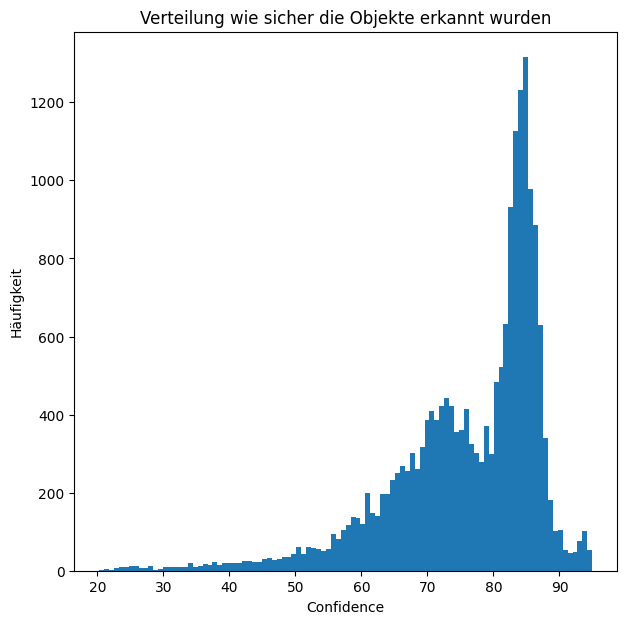

In [30]:
plt.figure(figsize=(7, 7))
plt.hist(data["confidence"], bins=100)
plt.title("Verteilung wie sicher die Objekte erkannt wurden")
plt.xlabel("Confidence")
plt.ylabel("Häufigkeit")
plt.show()

Wie man sieht die Zed-Kamera scheint sich bei den meisten erkennungen über 70% sicher zu sein. Meistens sogar über 80%. Wir analysieren aber vorallem noch die objekte zwischen 20% und 30%.

In [33]:
data.loc[data["confidence"] < 30].describe(include="all")

,frame,object,object_id,object_label,confidence,tracking_state,x,y,z,vx,xy,vz,width,height,length
count,92.000000,92.0,92.0,92,92.000000,92,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000
unique,NaN,4.0,2.0,1,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,1.0,1.0,Person,NaN,OK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,63.0,88.0,92,NaN,92,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,4184.728261,NaN,NaN,NaN,25.269219,NaN,-0.218814,-1.584936,9.283510,-0.028240,-0.004968,0.216523,0.723747,1.633381,0.723748
std,2797.739516,NaN,NaN,NaN,2.284746,NaN,2.256650,0.199315,4.786178,0.669088,0.014006,0.655911,0.185178,0.123639,0.185178
min,113.000000,NaN,NaN,NaN,20.239260,NaN,-5.828517,-1.909414,-2.178091,-2.003810,-0.026910,-1.625280,0.507490,1.338940,0.507490
25%,1387.250000,NaN,NaN,NaN,23.776248,NaN,-0.869564,-1.656061,5.742151,-0.580740,-0.011987,-0.009320,0.578240,1.517490,0.578240
50%,4731.000000,NaN,NaN,NaN,25.134280,NaN,0.452100,-1.611304,10.886871,-0.009880,-0.009125,0.287275,0.693660,1.687020,0.693660
75%,6466.250000,NaN,NaN,NaN,26.995850,NaN,0.654543,-1.553524,11.983759,0.391267,0.001835,0.639360,0.810865,1.728342,0.810865


Glücklicherweise sind nur 92 frames betroffen. Wir schauen uns diese genauer an.
- Objects werden nur noch 4 erkannt. ????
- object_id sind immer noch 2, wobei die id 1 88 Mal vorkommt und die id 2 nur 4 Mal.
Die Frage die sich mir nun stellt ist, was sind diese Objekte und kommen bei mehr confidence auch mehr Objekte vor?

In [34]:
data.loc[data["confidence"] < 50].describe(include="all")

,frame,object,object_id,object_label,confidence,tracking_state,x,y,z,vx,xy,vz,width,height,length
count,645.000000,645.0,645.0,645,645.000000,645,645.000000,645.000000,645.000000,645.000000,645.000000,645.000000,645.000000,645.000000,645.000000
unique,NaN,6.0,2.0,1,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,1.0,1.0,Person,NaN,OK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,325.0,629.0,645,NaN,645,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,4486.782946,NaN,NaN,NaN,39.910539,NaN,0.070377,-1.628093,11.432772,-0.019717,-0.003743,0.164482,0.757895,1.621679,0.757895
std,3325.146913,NaN,NaN,NaN,7.871866,NaN,1.581315,0.138820,3.424508,0.712061,0.013502,0.603968,0.159379,0.111011,0.159379
min,7.000000,NaN,NaN,NaN,20.239260,NaN,-5.857681,-1.949037,-3.893990,-4.444040,-0.064910,-2.571660,0.500010,1.338940,0.500010
25%,1424.000000,NaN,NaN,NaN,34.863280,NaN,0.279184,-1.689653,10.895991,-0.326650,-0.010900,-0.193360,0.650250,1.526760,0.650250
50%,3928.000000,NaN,NaN,NaN,41.870120,NaN,0.463917,-1.632902,11.732230,0.031310,-0.002870,0.148440,0.733920,1.642650,0.733920
75%,7426.000000,NaN,NaN,NaN,46.484380,NaN,0.667017,-1.569864,13.752093,0.359440,0.003770,0.540140,0.821300,1.722670,0.821300


Bei 50% confidence sind wir nur bei 645 frames. Aber einzigartige "objects sind wieder 6 vorhanden.

# Generieren von mehr Features 

### Berechnung der Geschwindigkeit

In [38]:
# Geschwindigkeit berechnen mit den drei Achsen
data["geschwindigkeit"] = np.sqrt(data["vx"]**2 + data["xy"]**2 + data["vz"]**2)

### Berechnung der Beschleunigung

In [41]:
# Sicherstellen das die Daten sortiert sind um die Beschleunigung zu berechnen mit der Differenz des vorherigen Frames
data = data.sort_values(by=["object_id", "frame"])
data["beschleunigung"] = data.groupby("object_id")["geschwindigkeit"].diff().fillna(0)

In [44]:
#Reihenfolge wieder herstellen
data = data.sort_values(by=["frame"])

### Feldzonen berechnen

In [63]:
def zonen(y):
    abs_y = abs(y)
    if abs_y > 6.4: # Vom Netz bis zur Aufschlaglinie
        return "Sehr Offensiv"
    elif 11 > abs_y: #Bis fast zur Grundlinie
        return "Offensiv"
    elif 12.1 > abs_y: # Etwas hinter der Grundlinie
        return "Neutral"
    else:  # Deutlich hinter der Grundlinie
        return "Defensiv"

In [64]:
def position(x):
    def_grenze = 2.74
    if x > def_grenze:
        return 'Rechts'
    elif x < -def_grenze:
        return 'Links'
    else:
        return 'Mitte'

In [65]:
data["zone"] = data["z"].apply(zonen)
data["position"] = data["x"].apply(position)

## Vertiefte Analyse

In [66]:
data.head()

,frame,object,object_id,object_label,confidence,tracking_state,x,y,z,vx,xy,vz,width,height,length,geschwindigkeit,beschleunigung,zone,position
1,3,1,1,Person,58.69141,OK,0.491703,-1.808712,13.248981,-3.77620,0.20816,-10.44296,0.79609,1.36517,0.79609,11.106684,0.000000,Sehr Offensiv,Mitte
3,4,1,1,Person,57.95898,OK,0.545964,-1.802297,13.155637,-2.49269,0.16367,-8.05950,0.78589,1.36619,0.78589,8.437762,-2.668922,Sehr Offensiv,Mitte
5,5,1,1,Person,55.90820,OK,0.490332,-1.803161,13.285841,-1.44754,0.09919,-4.91755,0.77365,1.37026,0.77365,5.127135,-3.310628,Sehr Offensiv,Mitte
7,6,1,1,Person,50.00000,OK,0.491634,-1.801160,13.310953,-1.10440,0.07878,-3.91267,0.75425,1.37394,0.75425,4.066312,-1.060823,Sehr Offensiv,Mitte
9,7,1,1,Person,37.01172,OK,0.444338,-1.802547,13.393477,-0.81841,0.05096,-2.55268,0.73128,1.37605,0.73128,2.681150,-1.385162,Sehr Offensiv,Mitte
